In [ ]:
!pip install transformers

     |████████████████████████████████| 573kB 3.4MB/s 
     |████████████████████████████████| 870kB 15.9MB/s 
     |████████████████████████████████| 1.0MB 19.6MB/s 
     |████████████████████████████████| 3.7MB 29.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=81d41ea7c565816807c272d80dd9be167582e2e52bf808a1564b62ea3288783e
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [ ]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [ ]:
path = Path('data/twitter')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data/twitter')

In [ ]:
!kaggle competitions download -c tweet-sentiment-extraction -p {path}


  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 70.2MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 101MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 79.1MB/s]


In [ ]:
! unzip -q -n {path}/train.csv.zip -d {path}

In [ ]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [ ]:
from fastai.core import *
import transformers; transformers.__version__

'2.8.0'

In [ ]:
KAGGLE_WORKING = Path("/kaggle/working")

In [ ]:
train_df = train_df.dropna().reset_index(drop=True)

In [ ]:
max(len(o.split()) for o in array(train_df['text']))

33

In [ ]:
train_df.sentiment.value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [ ]:
def get_answer_start(context, answer):
    len_a = len(answer)
    for i, _ in enumerate(context):
        if context[i:i+len_a] == answer: return i
    raise Exception("No overlapping segment found")

In [ ]:
def generate_qas_dict(text_id, context, answer, question):
    qas_dict = {}
    qas_dict['question'] = question
    qas_dict['id'] = text_id
    qas_dict['is_impossible'] = False
    
    if answer is None: 
        qas_dict['answers'] = []
    else: 
        answer_start = get_answer_start(context, answer)
        qas_dict['answers'] = [{"text":answer, "answer_start":answer_start}]
    return qas_dict


In [ ]:
def create_squad_from_df(df):
    data_dicts = []
    for _, row in df.iterrows():
        text_id = row['textID']
        context = row['text']
        answer =  row['selected_text'] if 'selected_text' in row else None
        question = row['sentiment']

        qas_dict = generate_qas_dict(text_id, context, answer, question)
        data_dict = {"paragraphs" : [{"qas" : [qas_dict], "context":context}]}
        data_dict['title'] = text_id
        data_dicts.append(data_dict)

    return {"version": "v2.0", "data": data_dicts}

In [ ]:
train_no_neutral_df = train_df[train_df.sentiment != 'neutral'].reset_index(drop=True)
test_no_neutral_df = test_df[test_df.sentiment != 'neutral'].reset_index(drop=True)
train_no_neutral_df.shape, test_no_neutral_df.shape

NameError: ignored

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# create 5 fold trn-val splits with only positive/negative tweets
os.makedirs("squad_data", exist_ok=True)
kfold = KFold(5, shuffle=True, random_state=42)
fold_idxs = list(kfold.split(train_no_neutral_df))

for i, (trn_idx, val_idx) in enumerate(fold_idxs):
    _trn_fold_df = train_no_neutral_df.iloc[trn_idx]
    _val_fold_df = train_no_neutral_df.iloc[val_idx]
    train_squad_data = create_squad_from_df(_trn_fold_df)
    valid_squad_data = create_squad_from_df(_val_fold_df)
    with open(f"squad_data/train_squad_data_{i}.json", "w") as f: f.write(json.dumps(train_squad_data))
    with open(f"squad_data/valid_squad_data_{i}.json", "w") as f: f.write(json.dumps(valid_squad_data))

In [ ]:
# create for test 
test_squad_data =  create_squad_from_df(test_df)
with open("squad_data/test_squad_data.json", "w") as f: f.write(json.dumps(test_squad_data))

In [ ]:
_train_dict = json.loads(open('squad_data/train_squad_data_0.json').read())

In [ ]:
sample_idx = np.random.choice(range(len(_train_dict['data'])))
_train_dict['data'][sample_idx]

{'paragraphs': [{'context': 'thanks so much for the discount code. looking forward to trying your pads out',
   'qas': [{'answers': [{'answer_start': 0,
       'text': 'thanks so much for the discount code.'}],
     'id': '908bbe2865',
     'is_impossible': False,
     'question': 'positive'}]}],
 'title': '908bbe2865'}

In [ ]:
textid = _train_dict['data'][sample_idx]['paragraphs'][0]['qas'][0]['id']

In [ ]:
train_df[train_df.textID == textid]

,textID,text,selected_text,sentiment
21173,2d8486baf2,hmm Have to admit was a good episode and his ...,good,positive


In [ ]:
from fastai.text import *
from transformers import AutoTokenizer, AutoConfig, AutoModel, AutoModelForQuestionAnswering
from transformers.data.processors.squad import SquadResult, SquadV1Processor, SquadV2Processor, SquadExample, squad_convert_examples_to_features

In [ ]:
PRETRAINED_TYPE = 'albert-xlarge-v2'
# PRETRAINED_TYPE = 'distilbert-base-uncased'

In [ ]:
processor = SquadV2Processor()
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_TYPE, do_lower_case=True)

In [ ]:
sample_examples = processor.get_train_examples('squad_data', 'train_squad_data_0.json')

100%|██████████| 13090/13090 [00:00<00:00, 30615.80it/s]


In [ ]:
sample_example = sample_examples[sample_idx]
sample_example.context_text, sample_example.question_text, sample_example.answer_text, sample_example.qas_id

('thanks so much for the discount code. looking forward to trying your pads out',
 'positive',
 'thanks so much for the discount code.',
 '908bbe2865')

In [ ]:
max_seq_length = 192
max_query_length = 10

def get_dataset(examples, is_training):
    return squad_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        doc_stride=200,
        max_seq_length=max_seq_length,
        max_query_length=10,
        is_training=is_training,
        return_dataset="pt",
        threads=defaults.cpus,
    )

In [ ]:
sample_feature, sample_dataset = get_dataset([sample_example], True)

NameError: ignored

In [ ]:
start_idx, end_idx = sample_dataset.tensors[3][0].item(), sample_dataset.tensors[4][0].item()
tokenizer.convert_ids_to_tokens(sample_dataset.tensors[0][0])[start_idx:end_idx+1]

['▁good']

In [ ]:
class SQUAD_Dataset(Dataset):
    def __init__(self, dataset_tensors, examples, is_training=True):
        self.dataset_tensors = dataset_tensors
        self.examples = examples
        self.is_training = is_training
        
        
    def __getitem__(self, idx):
        'fastai requires (xb, yb) to return'
        'AutoModel handles loss computation in forward hence yb will be None'
        input_ids = self.dataset_tensors[0][idx]
        attention_mask = self.dataset_tensors[1][idx]
        token_type_ids = self.dataset_tensors[2][idx]
        xb = (input_ids, attention_mask, token_type_ids)
        if self.is_training: 
            start_positions = self.dataset_tensors[3][idx]
            end_positions = self.dataset_tensors[4][idx]
            xb = (input_ids, attention_mask, token_type_ids, start_positions, end_positions)
        yb = 0
        return xb, yb
    
    def __len__(self): return len(self.dataset_tensors[0])

In [ ]:
def get_fold_ds(foldnum):
    data_dir = "squad_data"
    train_filename = f"train_squad_data_{foldnum}.json"
    valid_filename = f"valid_squad_data_{foldnum}.json"
    test_filename = "test_squad_data.json"
    
    # tokenize
    train_examples = processor.get_train_examples(data_dir, train_filename)
    valid_examples = processor.get_train_examples(data_dir, valid_filename)
    test_examples = processor.get_dev_examples(data_dir, test_filename)

    # create tensor dataset
    train_features, train_dataset = get_dataset(train_examples, True)
    valid_features, valid_dataset = get_dataset(valid_examples, True)
    test_features, test_dataset = get_dataset(test_examples, False)
    
    # create pytorch dataset
    train_ds = SQUAD_Dataset(train_dataset.tensors, train_examples)
    valid_ds = SQUAD_Dataset(valid_dataset.tensors, valid_examples)
    test_ds = SQUAD_Dataset(test_dataset.tensors, test_examples, False)
    
    return train_ds, valid_ds, test_ds    

In [ ]:
from transformers import AutoModelForPreTraining,  AlbertForQuestionAnswering

In [ ]:
# MODEL_TYPE = 'distilbert'
MODEL_TYPE = 'albert'

In [ ]:
train_ds, valid_ds, test_ds  = get_fold_ds(0)

add example index and unique id: 100%|██████████| 3534/3534 [00:00<00:00, 929262.76it/s]


In [ ]:
model = AlbertForQuestionAnswering.from_pretrained(PRETRAINED_TYPE)

In [ ]:
data = DataBunch.create(train_ds, valid_ds, test_ds, path=".", bs=3)

In [ ]:
xb,yb = data.one_batch()

In [ ]:
xb[4]

tensor([ 4, 19, 21])

In [ ]:
model

AlbertForQuestionAnswering(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=2048, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((2048,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=2048, out_features=2048, bias=True)
                (key): Linear(in_features=2048, out_features=2048, bias=True)
                (value): Linear(in_features=2048, out_features=20

In [ ]:
class ModelWrapper(Module):
    def __init__(self, model): self.model = model
    def forward(self, *xargs):
        inp = {}
        inp["input_ids"] = xargs[0]
        inp["attention_mask"] = xargs[1]
        inp["token_type_ids"] = xargs[2]
        if len(xargs) == 5: inp["start_positions"], inp[ "end_positions"] = xargs[3], xargs[4]
        elif len(xargs) == 3: pass
        else: raise Exception(f"Invalid Number of Inputs {len(xargs)}")
        return self.model(**inp)

In [ ]:
tse_model = TSEModel(model)

In [ ]:
loss, start_logits, end_logits = tse_model(*xb)

In [ ]:
yb

[tensor([9, 5]), tensor([11,  5])]

In [ ]:
class DummyLoss(Module):
    'loss is always first argument in model output'
    def __init__(self): pass
    def forward(self, input, targets): return input[0]

In [ ]:
def model_split_func(m): return (m.model.albert.embeddings,
              m.model.albert.encoder,               
              m.model.albert.pooler,
              m.model.qa_outputs)

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
def get_best_start_end_idxs(_start_logits, _end_logits):
    best_logit = tensor([-1e6]).cuda().half()
    best_idxs = None
    for start_idx, start_logit in enumerate(_start_logits):
        for end_idx, end_logit in enumerate(_end_logits[start_idx:]):
            logit_sum = (start_logit + end_logit) 
            if logit_sum > best_logit:
                best_logit = logit_sum
                best_idxs = (start_idx, start_idx+end_idx)
    return best_idxs

In [ ]:
class JaccardScore(Callback):
    "Stores predictions and targets to perform calculations on epoch end."
    def __init__(self): 
        pass
        
    def on_epoch_begin(self, **kwargs):
        self.jaccard_scores = []        

    def on_batch_end(self, last_input:Tensor, last_output:Tensor, last_target:Tensor, **kwargs):
        
        input_ids = last_input[0]
        attention_masks = last_input[1].bool()
        token_type_ids = last_input[2].bool()
        start_positions = last_input[3]
        end_positions = last_input[4]
        
        loss, start_logits, end_logits = last_output
        
        # mask select only context part
        for i in range(len(input_ids)):
            _input_ids = input_ids[i].masked_select(token_type_ids[i])
            _start_logits = start_logits[i].masked_select(token_type_ids[i])
            _end_logits = end_logits[i].masked_select(token_type_ids[i])
            _start_pos = start_positions[i].item()
            _end_pos = end_positions[i].item()
            _answer_text = tokenizer.decode(input_ids[i][_start_pos:_end_pos+1])
            best_idxs = get_best_start_end_idxs(_start_logits, _end_logits)
            _answer = tokenizer.decode(_input_ids[best_idxs[0]:best_idxs[1]+1])
            score = jaccard(_answer, _answer_text)
            self.jaccard_scores.append(score)
            
        
    def on_epoch_end(self, last_metrics, **kwargs):        
        res = np.mean(self.jaccard_scores)
        return add_metrics(last_metrics, res)

In [ ]:
from fastai.callbacks import *

In [ ]:
 train_ds, valid_ds, test_ds = get_fold_ds(0)

add example index and unique id: 100%|██████████| 3534/3534 [00:00<00:00, 961262.67it/s]


In [ ]:
data = DataBunch.create(train_ds, valid_ds, test_ds, path=".", bs=16)

In [ ]:
transformer_model = AlbertForQuestionAnswering.from_pretrained(PRETRAINED_TYPE)

In [ ]:
wrapped_model = ModelWrapper(transformer_model)

In [ ]:
custom_transformer_model = TSEModel(model = transformer_model)

In [ ]:
loss_fn = DummyLoss()

In [ ]:
!pip install torch_optimizer

In [ ]:
import torch_optimizer as optim

In [ ]:
opt_func_Yogi = partial(optim.Yogi, betas=(0.95, 0.999), eps=1e-6, weight_decay=0)

In [ ]:
from transformers import AdamW

In [ ]:
CustomAdamW = partial(AdamW, correct_bias=False)

In [ ]:
learner = Learner(data, wrapped_model, loss_func=loss_fn, opt_func = CustomAdamW,metrics=[JaccardScore()], model_dir=f"models_fold_{0}")

In [ ]:
learner.split(model_split_func)

Learner(data=DataBunch;

Train: <__main__.SQUAD_Dataset object at 0x7f529a2b2048>;

Valid: <__main__.SQUAD_Dataset object at 0x7f5293686080>;

Test: <__main__.SQUAD_Dataset object at 0x7f5294799198>, model=ModelWrapper(
  (model): AlbertForQuestionAnswering(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=2048, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((2048,), eps=1e-12, elementwise_affine=True)
      

In [ ]:
learner.callbacks.append(ShowGraph(learner))

In [ ]:
learner.to_fp16()

Learner(data=DataBunch;

Train: <__main__.SQUAD_Dataset object at 0x7f529a2b2048>;

Valid: <__main__.SQUAD_Dataset object at 0x7f5293686080>;

Test: <__main__.SQUAD_Dataset object at 0x7f5294799198>, model=ModelWrapper(
  (model): AlbertForQuestionAnswering(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=2048, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((2048,), eps=1e-12, elementwise_affine=True)
      

In [ ]:
learner.save('untrainfinetune')

In [ ]:
learner.load('untrainfinetune');

In [ ]:
learner.freeze_to(-1)

In [ ]:
early_stop_cb = EarlyStoppingCallback(learner, monitor='jaccard_score',mode='max',patience=2)
save_model_cb = SaveModelCallback(learner,every='improvement',monitor='jaccard_score',name='albert-qa-finetunethirdcycle_fold0')

In [ ]:
learner.data = data

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,jaccard_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-03
Min loss divided by 10: 1.10E-03


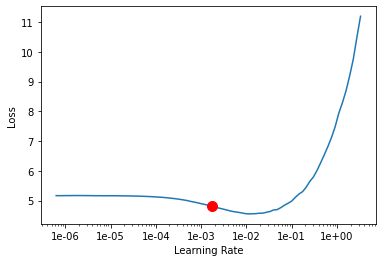

In [ ]:
learner.recorder.plot(suggestion = True)

In [ ]:
lr = 2e-3

epoch,train_loss,valid_loss,jaccard_score,time
0,3.028645,2.381390,0.356009,16:44
1,2.298399,2.124851,0.376519,16:45
2,2.114939,2.064876,0.389360,16:45
3,2.050017,2.044089,0.393216,16:45
4,2.038051,2.039954,0.392363,16:46


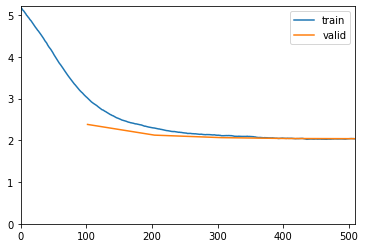

Better model found at epoch 0 with jaccard_score value: 0.3560087327406398.
Better model found at epoch 1 with jaccard_score value: 0.37651866927206323.
Better model found at epoch 2 with jaccard_score value: 0.389359597702522.
Better model found at epoch 3 with jaccard_score value: 0.3932155731682105.


In [ ]:
learner.fit_one_cycle(5, lr, callbacks=[early_stop_cb, save_model_cb])

In [ ]:
learner.predict('This is such a nice day')

AttributeError: ignored

In [ ]:
learner.load('albert-qa-finetune_fold0');

In [ ]:
learner.freeze_to(-2)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,jaccard_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 7.59E-08


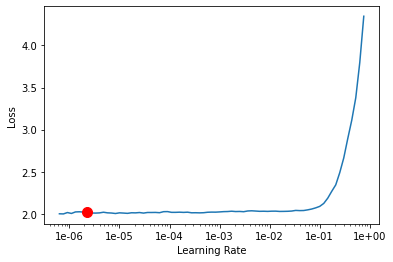

In [ ]:
learner.recorder.plot(suggestion = True)

In [ ]:
lr = 1e-6

epoch,train_loss,valid_loss,jaccard_score,time
0,2.025366,2.043937,0.393728,16:45
1,2.027895,2.043708,0.393682,16:45
2,2.031791,2.043478,0.393682,16:45


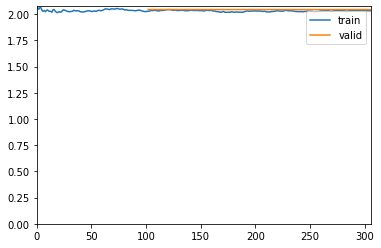

Better model found at epoch 0 with jaccard_score value: 0.3937279993424688.


In [ ]:
learner.fit_one_cycle(3, max_lr=slice(lr*0.95**5, lr), moms=(0.8, 0.9), callbacks=[early_stop_cb, save_model_cb])

In [ ]:
learner.load('albert-qa-finetunesecondcycle_fold0')

Learner(data=DataBunch;

Train: <__main__.SQUAD_Dataset object at 0x7f529a2b2048>;

Valid: <__main__.SQUAD_Dataset object at 0x7f5293686080>;

Test: <__main__.SQUAD_Dataset object at 0x7f5294799198>, model=ModelWrapper(
  (model): AlbertForQuestionAnswering(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=2048, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((2048,), eps=1e-12, elementwise_affine=True)
      

In [ ]:
learner.freeze_to(-3)

In [ ]:
learner.data = data

In [ ]:
learner.opt_func = CustomAdamW

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,jaccard_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


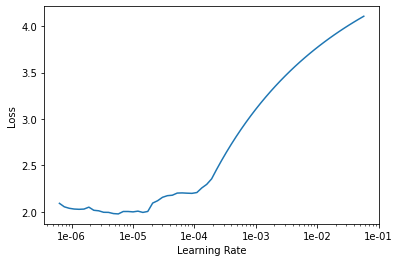

In [ ]:
learner.recorder.plot()

In [ ]:
lr = 1e-6

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**5, lr), moms=(0.8, 0.9), callbacks=[early_stop_cb, save_model_cb])

epoch,train_loss,valid_loss,jaccard_score,time
